In [48]:
from IPython.display import Image, display, Markdown

In [1]:
from langchain_core.tools.base import BaseToolkit

Decompose the Problem: CoT prompts guide the model to break down a complex question into manageable steps, akin to how a human might solve the problem.
Guide with Exemplars: CoT uses examples that demonstrate reasoning steps, helping the model grasp the method needed to reach the correct answer.

Zero-Shot CoT and CoT Prompting both aim to improve model responses and extract more accurate answers by generating logic-based reasoning. In Zero-Shot CoT, however, we do not have to include input exemplars of Chain-of-Thought responses, but rather just append the words "Let's think step by step" to the end of an input.

Example:

> If John has 5 pears, then eats 2, and buys 5 more, then gives 3 to his friend, how many pears does he have?
> 
> Let's think step by step.

In [4]:
import os
import pandas as pd
import numpy as np
from typing import TypedDict, List, Optional, Dict, Any
from sklearn.impute import SimpleImputer
from langgraph.graph import StateGraph, END


In [152]:
def print_state(state):
    if not "messages" in state:
        return

    for message in state["messages"]:
        if isinstance(message, SystemMessage):
            print("💻" * 15, "SYSTEM MESSAGE", "💻" * 15)

        elif isinstance(message, AIMessage):
            print("🤖" * 15, "AI MESSAGE", "🤖" * 15)

            if hasattr(message, "tool_calls"):
                print(message.tool_calls)

        elif isinstance(message, HumanMessage):
            print(" " * 40, "👱🏻‍♀️" * 15, "HUMAN MESSAGE", "👱🏻‍♀️" * 15)
            message.content = " " * 30 + message.content

        else:
            print("🔨" * 15, "TOOL MESSAGE", "🔨" * 15)

        print(message.content)
        print("🚀" * 50)
        print("\n\n")

## Agent v1

### Tools

In [ ]:
# --- 2. Define Cleaning Tools ---

def drop_high_null_columns(df: dict, null_threshold_percent: float = 50.0) -> Dict[str, Any]:
    """
    Drops columns from the DataFrame where the percentage of missing values
    (NaN or empty string) exceeds the specified threshold.
    Args:
        df (pd.DataFrame): The input DataFrame.
        null_threshold_percent (float): The percentage threshold (0-100). Default is 50.
    Returns:
        Dict[str, Any]: A dictionary containing the modified DataFrame under the key 'dataframe'
                        and a status message under the key 'status'.
    """
    print(f"--- Calling drop_high_null_columns (threshold: {null_threshold_percent}%) ---")
    if df is None:
         return {"dataframe": None, "status": "Error: No DataFrame provided."}

    df = pd.DataFrame.from_dict(df)
    # Consider both NaN and empty strings as missing
    df_copy = df.replace('', np.nan)
    initial_cols = set(df_copy.columns)
    threshold = null_threshold_percent / 100.0
    cols_to_drop = []

    for col in df_copy.columns:
        null_ratio = df_copy[col].isnull().sum() / len(df_copy)
        if null_ratio > threshold:
            cols_to_drop.append(col)

    if not cols_to_drop:
        status = f"No columns found with missing values > {null_threshold_percent}%."
        print(f"--- Status: {status} ---")
        return {"dataframe": df, "status": status} # Return original df if no changes
    else:
        df_cleaned = df.drop(columns=cols_to_drop) # Drop from the original df
        dropped_cols_str = ", ".join(cols_to_drop)
        status = f"Dropped {len(cols_to_drop)} columns ({dropped_cols_str}) with > {null_threshold_percent}% missing values."
        print(f"--- Status: {status} ---")
        return {"dataframe": df_cleaned.to_dict(), "status": status}

def drop_all_null_rows(df: dict) -> Dict[str, Any]:
    """
    Drops rows from the DataFrame where all values are missing (NaN or empty string).
    Args:
        df (pd.DataFrame): The input DataFrame.
    Returns:
        Dict[str, Any]: A dictionary containing the modified DataFrame under the key 'dataframe'
                        and a status message under the key 'status'.
    """
    print("--- Calling drop_all_null_rows ---")
    if df is None:
         return {"dataframe": None, "status": "Error: No DataFrame provided."}

    df = pd.DataFrame.from_dict(df)

    initial_rows = len(df)
    # Replace empty strings with NaN to use dropna effectively
    df_copy = df.replace('', np.nan)
    df_cleaned_temp = df_copy.dropna(how='all')

    # Get the indices of rows that were kept
    kept_indices = df_cleaned_temp.index

    # Use the kept indices to filter the original DataFrame (preserving original values like '')
    df_cleaned = df.loc[kept_indices]

    rows_dropped = initial_rows - len(df_cleaned)

    if rows_dropped > 0:
        status = f"Dropped {rows_dropped} rows where all values were missing."
    else:
        status = "No all-missing rows found to drop."

    print(f"--- Status: {status} ---")
    return {"dataframe": df_cleaned.to_dict(), "status": status}


def impute_missing_values(df: dict) -> Dict[str, Any]:
    """
    Imputes missing values (NaN or empty string) in the DataFrame.
    Uses median for numerical columns and mode (most frequent) for categorical/object columns.
    Args:
        df (pd.DataFrame): The input DataFrame.
    Returns:
        Dict[str, Any]: A dictionary containing the modified DataFrame under the key 'dataframe'
                        and a status message under the key 'status'.
    """
    print("--- Calling impute_missing_values ---")
    if df is None:
         return {"dataframe": None, "status": "Error: No DataFrame provided."}

    df = pd.DataFrame.from_dict(df)

    df_cleaned = df.copy()
    df_cleaned = df_cleaned.replace('', np.nan) # Treat empty strings as NaN for imputation

    imputed_cols = []
    numerical_cols = df_cleaned.select_dtypes(include=np.number).columns
    categorical_cols = df_cleaned.select_dtypes(include=['object', 'category']).columns

    # Impute numerical columns
    if not df_cleaned[numerical_cols].isnull().sum().sum() == 0:
        num_imputer = SimpleImputer(strategy='median')
        df_cleaned[numerical_cols] = num_imputer.fit_transform(df_cleaned[numerical_cols])
        imputed_cols.extend([col for col in numerical_cols if df[col].replace('', np.nan).isnull().any()]) # Check original df for missingness
        print(f"--- Imputed numerical columns (median): {[col for col in numerical_cols if df[col].replace('', np.nan).isnull().any()]} ---")

    # Impute categorical columns
    if not df_cleaned[categorical_cols].isnull().sum().sum() == 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df_cleaned[categorical_cols] = cat_imputer.fit_transform(df_cleaned[categorical_cols])
        imputed_cols.extend([col for col in categorical_cols if df[col].replace('', np.nan).isnull().any()]) # Check original df for missingness
        print(f"--- Imputed categorical columns (mode): {[col for col in categorical_cols if df[col].replace('', np.nan).isnull().any()]} ---")

    if imputed_cols:
        status = f"Imputed missing values in columns: {', '.join(sorted(list(set(imputed_cols))))} (Numerical: Median, Categorical: Mode)."
    else:
        status = "No missing values found to impute."

    print(f"--- Status: {status} ---")
    return {"dataframe": df_cleaned.to_dict(), "status": status}


tools = [drop_high_null_columns, drop_all_null_rows, impute_missing_values]



In [35]:
from langchain_core.tools.base import BaseTool

In [37]:
class DropColumnTool(BaseTool):
    name: str = "drop_high_null_columns"
    description: str = """
    Drops columns from the DataFrame where the percentage of missing values
    (NaN or empty string) exceeds the specified threshold.
    """
    def _run(self, df):
        return drop_high_null_columns(df)


class DropRowTool(BaseTool):
    name: str = "drop_all_null_rows"
    description: str = """
    Drops rows from the DataFrame where all values are missing (NaN or empty string).
    """
    def _run(self, df):
        return drop_all_null_rows(df)


class ImputeTool(BaseTool):
    name: str = "drop_all_null_rows"
    description: str = """
    Imputes missing values (NaN or empty string) in the DataFrame.
    Uses median for numerical columns and mode (most frequent) for categorical/object columns.
    """
    def _run(self, df):
        return impute_missing_values(df)

tools = [DropColumnTool(), DropRowTool(), ImputeTool()]
tools

[DropColumnTool(), DropRowTool(), ImputeTool()]

In [38]:
[t.name for t in tools]

['drop_high_null_columns', 'drop_all_null_rows', 'drop_all_null_rows']

### Nodes

In [54]:
# --- 3. Define Agent State ---
class DataCleaningState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    dataframe: pd.DataFrame  # The actual data being cleaned
    data_summary: str        # Text summary for the LLM
    original_file_path: str  # Keep track of the source


In [ ]:
def call_data_cleaning_agent(state: DataCleaningState, config: RunnableConfig):
    """Invokes the LLM to decide the next cleaning step or generate a final response."""
    print("--- Calling LLM Agent ---")
    messages = state['messages']

    current_summary = state['data_summary']  # Provide the latest data summary to the LLM
    summary_message = HumanMessage(content=f"Here is the current state of the data:\n\n{current_summary}\n\nBased *only* on this summary, what cleaning step should be taken next using the available tools? If the data looks sufficiently clean (e.g., no obvious high null columns, no all-null rows needing removal, and imputation has been attempted if needed), respond with a final assessment and do not call any tools.")

    model = llm
    model_with_tools = model.bind_tools(tools)
    llm_messages = messages + [summary_message]

    print("--- Sending to LLM ---")
    print("Messages sent: ")
    print([m.pretty_repr() for m in llm_messages])
    response: AIMessage = model_with_tools.invoke(llm_messages, config=config)
    print(f"--- LLM Response: {response.content} ---")
    print(f"--- LLM Tool Calls: {response.tool_calls} ---")

    return {"messages": [response]}


In [ ]:
# Node 2: Executes tools
def execute_cleaning_tool(state: DataCleaningState):
    """Executes the cleaning tool called by the LLM."""
    print("--- Executing Tool ---")
    last_message: AIMessage = state['messages'][-1] # Get the latest AI message

    if not last_message.tool_calls:
        print("--- ERROR: No tool calls found in the last message, but Action node was reached. ---")
        # This case should ideally not be reached due to the conditional edge
        # Add a message indicating potential confusion or end of planned tool use
        no_tool_message = ToolMessage(content="No tool call was specified by the agent in the previous step.", tool_call_id="error_no_tool")
        return {"messages": [no_tool_message]}

    tool_messages: List[ToolMessage] = []
    current_df = state['dataframe'] # Get the dataframe to operate on
    new_df = current_df # Start with the current df

    for tool_call in last_message.tool_calls:
        tool_name = tool_call["name"]
        print(f"--- Preparing Tool: {tool_name} ---")
        print(f"--- Arguments: {tool_call['args']} ---")

        selected_tool = None
        for t in tools:
            if t.name == tool_name:
                selected_tool = t
                break

        if selected_tool:
            try:
                tool_output_dict = selected_tool.invoke({**tool_call["args"], "df": new_df})
                new_df = tool_output_dict.get("dataframe", new_df)
                status_message = tool_output_dict.get("status", "Tool executed but provided no status.")

                print(f"--- Tool Status: {status_message} ---")
                tool_messages.append(
                    ToolMessage(content=status_message, tool_call_id=tool_call["id"])
                )
            except Exception as e:
                print(f"--- ERROR executing tool {tool_name}: {e} ---")
                error_message = f"Error executing tool {tool_name}: {str(e)}"
                tool_messages.append(
                    ToolMessage(content=error_message, tool_call_id=tool_call["id"])
                )
        else:
            print(f"--- ERROR: Tool '{tool_name}' not found ---")
            tool_messages.append(
                 ToolMessage(content=f"Error: Tool '{tool_name}' not found.", tool_call_id=tool_call["id"])
            )

    new_summary = get_data_summary(new_df)
    print("--- Data Summary Updated ---")

    return {
        "messages": tool_messages,
        "dataframe": new_df,
        "data_summary": new_summary,
    }

In [ ]:
def should_continue_cleaning(state: DataCleaningState) -> str:
    """Determines whether to continue cleaning (call a tool) or end."""
    print("--- Checking Condition: Should Continue Cleaning? ---")
    last_message = state['messages'][-1]

    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        print("--- Decision: Continue (Execute Tool) ---")
        return "execute_tool"
    else:
        print("--- Decision: End Cleaning Cycle ---")
        return END

### Graph

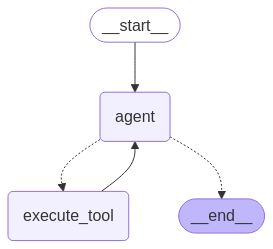

In [55]:
workflow = StateGraph(DataCleaningState)
workflow.add_node("agent", call_data_cleaning_agent)
workflow.add_node("execute_tool", execute_cleaning_tool)

workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    should_continue_cleaning,
    {
        "execute_tool": "execute_tool",
        END: END
    }
)
workflow.add_edge("execute_tool", "agent")
data_cleaning_app = workflow.compile()

display(Image(data_cleaning_app.get_graph().draw_mermaid_png()))

def run_data_cleaning_agent(file_path: str, output_file_path: str = "cleaned_data.csv"):
    """Loads data, runs the cleaning agent, and saves the result."""
    print(f"\n--- Starting Data Cleaning for: {file_path} ---")

    df = pd.read_csv(file_path)
    initial_summary = get_data_summary(df)
    initial_state = DataCleaningState(
        messages=[
            SystemMessage(content="You are an expert data cleaning agent. Your goal is to iteratively clean the provided dataset using the available tools (`drop_high_null_columns`, `drop_all_null_rows`, `impute_missing_values`). Analyze the data summary provided at each step and decide the most appropriate cleaning action. Ask for clarification if needed, but prioritize using the tools to address issues like high null percentages, all-null rows, or missing values needing imputation. When you believe the data is sufficiently clean based on the summary, provide a final response summarizing the cleaning process and state that cleaning is complete, without calling any more tools."),
            HumanMessage(content=f"Please clean the data from the file: {os.path.basename(file_path)}. Start by analyzing the initial summary.")
        ],
        dataframe=df,
        data_summary=initial_summary,
        original_file_path=file_path
    )

    print("\n--- Running Cleaning Workflow ---")
    final_state = None
    config = RunnableConfig(recursion_limit=10) 
    step_counter = 0
    max_steps = 8

    for output in data_cleaning_app.stream(initial_state, config=config, stream_mode="values"):
        step_counter += 1
        print(f"\n--- Cleaning Step {step_counter} Completed ---")
        last_node = list(output.keys())[-1]
        print(f"--- Last Node Executed: {last_node} ---")
        # print(f"--- Current Data Shape: {output['dataframe'].shape if output['dataframe'] is not None else 'N/A'} ---")
        # print("--- Current Messages ---")
        # for msg in output['messages']:
        #      print(f"  {msg.type.upper()}: {msg.content[:150]}...") # Print truncated message content
        # print("-" * 30)
        final_state = output # Keep track of the latest state
        if step_counter >= max_steps:
            print(f"--- Reached maximum steps ({max_steps}), stopping execution. ---")
            break

    if final_state is None:
         print("--- ERROR: Workflow did not produce a final state. ---")
         return

    # --- Process Final Result ---
    print("\n--- Cleaning Workflow Finished ---")
    final_df = final_state['dataframe']
    final_summary = final_state['data_summary']
    final_messages = final_state['messages']

    print("\n--- Final Data Summary ---")
    print(final_summary)

    print("\n--- Final Agent Message ---")
    if final_messages and isinstance(final_messages[-1], AIMessage):
        print(final_messages[-1].content)
    elif final_messages and isinstance(final_messages[-1], ToolMessage):
         print(f"(Ended after tool execution: {final_messages[-1].content})")
    else:
        print("(No final AI message found)")

    if final_df is not None:
        final_df.to_csv(output_file_path, index=False)
        print(f"\n--- Cleaned data saved to: {output_file_path} ---")
    else:
        print("--- WARNING: Final DataFrame is None, nothing to save. ---")



In [ ]:
# --- 9. Example Usage ---

# Create a dummy CSV for testing
dummy_data = {
    'ID': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Name': ['Alice', 'Bob', '', 'David', 'Eve', 'Frank', 'Grace', 'Heidi', 'Ivan', 'Judy'],
    'Age': [25, 30, 35, None, 28, 45, 22, 38, '', 50],
    'City': ['NY', 'SF', 'LA', 'NY', None, 'SF', 'LA', 'SF', 'NY', ''],
    'Salary': [50000, 60000, 70000, 55000, None, 90000, 45000, 80000, 65000, None],
    'HighNullCol': [None] * 7 + [1, 2, 3], # >50% null
    'AllNullRowIndicator': [None] * 10, # To test row drop
    'MixedNulls': [10, None, 30, '', 50, None, 70, 80, 90, 100]
}
dummy_df = pd.DataFrame(dummy_data)
# Add an all-null row
all_null_row = pd.DataFrame([[None]*len(dummy_df.columns)], columns=dummy_df.columns)
dummy_df = pd.concat([dummy_df, all_null_row], ignore_index=True)

# Add another all-null row with empty strings
all_empty_row = pd.DataFrame([['']*len(dummy_df.columns)], columns=dummy_df.columns)
dummy_df = pd.concat([dummy_df, all_empty_row], ignore_index=True)

dummy_csv_path = "dummy_data_to_clean.csv"
dummy_df.to_csv(dummy_csv_path, index=False)
print(f"Created dummy CSV: {dummy_csv_path}")



#### Nodes

In [5]:

# --- 1. Define Agent State ---

class CleaningState(TypedDict):
    """Represents the state of our data cleaning pipeline."""
    file_path: str               # Input CSV file path
    dataframe: Optional[pd.DataFrame] # The data being processed
    report: List[str]            # Log of actions performed
    null_threshold: float        # % threshold to drop columns
    imputation_results: Optional[Dict[str, Any]] # Store imputer details



In [ ]:
# --- 2. Define Cleaning Tool Functions (as Nodes) ---

def load_data(state: CleaningState) -> Dict[str, Any]:
    """Loads the initial data from the CSV file."""
    print("--- Node: load_data ---")
    file_path = state['file_path']
    report = state.get('report', []) # Initialize report if not present
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded data. Shape: {df.shape}")
        report.append(f"Loaded data from '{file_path}'. Initial shape: {df.shape}")
        return {"dataframe": df, "report": report}
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        report.append(f"Error: File not found at {file_path}. Stopping execution.")
        # Returning None for dataframe signals an issue, could also raise an exception
        # or add an error flag to the state if graph needs more complex error handling.
        return {"dataframe": None, "report": report}
    except Exception as e:
        print(f"Error loading CSV: {e}")
        report.append(f"Error loading CSV: {e}. Stopping execution.")
        return {"dataframe": None, "report": report}

def drop_high_null_columns(state: CleaningState) -> Dict[str, Any]:
    """Drops columns exceeding the null value threshold."""
    print("--- Node: drop_high_null_columns ---")
    df = state['dataframe']
    report = state['report']
    threshold = state['null_threshold']

    if df is None:
        report.append("Skipping drop_high_null_columns: DataFrame not loaded.")
        print("Skipping: DataFrame not loaded.")
        return {"report": report} # No change to dataframe

    initial_cols = df.shape[1]
    null_percentages = df.isnull().mean()
    cols_to_drop = null_percentages[null_percentages > threshold].index.tolist()

    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)
        dropped_cols_str = ", ".join(cols_to_drop)
        report.append(f"Dropped columns with >{threshold*100}% nulls: [{dropped_cols_str}].")
        print(f"Dropped columns: {cols_to_drop}")
        print(f"New shape: {df.shape}")
    else:
        report.append(f"No columns found with >{threshold*100}% null values.")
        print("No columns to drop based on threshold.")

    return {"dataframe": df, "report": report}

def drop_all_null_rows(state: CleaningState) -> Dict[str, Any]:
    """Drops rows where all values are null."""
    print("--- Node: drop_all_null_rows ---")
    df = state['dataframe']
    report = state['report']

    if df is None:
        report.append("Skipping drop_all_null_rows: DataFrame not available.")
        print("Skipping: DataFrame not available.")
        return {"report": report}

    initial_rows = df.shape[0]
    df = df.dropna(how='all')
    rows_dropped = initial_rows - df.shape[0]

    if rows_dropped > 0:
        report.append(f"Dropped {rows_dropped} rows containing all null values.")
        print(f"Dropped {rows_dropped} all-null rows.")
        print(f"New shape: {df.shape}")
    else:
        report.append("No rows found containing all null values.")
        print("No all-null rows to drop.")

    return {"dataframe": df, "report": report}


def impute_missing_values(state: CleaningState) -> Dict[str, Any]:
    """Imputes missing values (NaN and empty strings) based on column type."""
    print("--- Node: impute_missing_values ---")
    df = state['dataframe']
    report = state['report']
    imputation_summary = {} # Store details about imputation

    if df is None:
        report.append("Skipping impute_missing_values: DataFrame not available.")
        print("Skipping: DataFrame not available.")
        return {"report": report}

    # Replace empty strings with NaN to be caught by imputation
    df = df.replace(r'^\s*$', np.nan, regex=True)
    report.append("Replaced empty strings with NaN for imputation.")
    print("Replaced empty strings with NaN.")

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = df.select_dtypes(include='object').columns.tolist() # Simple typing

    imputed_cols_count = 0

    # Impute Numeric Columns (using median)
    if numeric_cols:
        num_imputer = SimpleImputer(strategy='median')
        # Only impute columns that actually have NaNs
        numeric_cols_with_nan = df[numeric_cols].isnull().any()
        cols_to_impute_num = numeric_cols_with_nan[numeric_cols_with_nan].index.tolist()
        if cols_to_impute_num:
            print(f"Imputing numeric columns (median): {cols_to_impute_num}")
            df[cols_to_impute_num] = num_imputer.fit_transform(df[cols_to_impute_num])
            imputation_summary['numeric_median'] = cols_to_impute_num
            imputed_cols_count += len(cols_to_impute_num)
        else:
            print("No numeric columns require imputation.")


    # Impute Categorical Columns (using most frequent)
    if categorical_cols:
        cat_imputer = SimpleImputer(strategy='most_frequent')
         # Only impute columns that actually have NaNs
        categorical_cols_with_nan = df[categorical_cols].isnull().any()
        cols_to_impute_cat = categorical_cols_with_nan[categorical_cols_with_nan].index.tolist()
        if cols_to_impute_cat:
            print(f"Imputing categorical columns (most_frequent): {cols_to_impute_cat}")
            df[cols_to_impute_cat] = cat_imputer.fit_transform(df[cols_to_impute_cat])
            imputation_summary['categorical_most_frequent'] = cols_to_impute_cat
            imputed_cols_count += len(cols_to_impute_cat)
        else:
            print("No categorical columns require imputation.")

    if imputed_cols_count > 0:
        report.append(f"Imputed missing values in {imputed_cols_count} column(s). Details: {imputation_summary}")
    else:
        report.append("No missing values found requiring imputation.")

    return {"dataframe": df, "report": report, "imputation_results": imputation_summary}



In [8]:
workflow = StateGraph(CleaningState)

workflow.add_node("load", load_data)
workflow.add_node("drop_cols", drop_high_null_columns)
workflow.add_node("drop_rows", drop_all_null_rows)
workflow.add_node("impute", impute_missing_values)

# Define the sequence of execution
workflow.set_entry_point("load")
workflow.add_edge("load", "drop_cols")
workflow.add_edge("drop_cols", "drop_rows")
workflow.add_edge("drop_rows", "impute")
workflow.add_edge("impute", END)

# Compile the graph
cleaning_agent = workflow.compile()


In [ ]:
data = {
    'ID': [1, 2, 3, 4, 5, 6, 7],
    'Name': ['Alice', 'Bob', '', 'David', 'Eve', 'Frank', 'Grace'],
    'Age': [25, 30, 35, None, 28, 45, 50],
    'City': ['New York', 'London', 'Paris', 'London', '', 'Sydney', None],
    'Salary': [50000, 60000, 75000, None, 55000, None, 90000],
    'HighNullCol': [None, None, None, None, None, 'Value', None], # >70% null
    'AllNullRowIndicator': [None, None, None, None, None, None, None] # Used to create an all-null row later
}
sample_df = pd.DataFrame(data)
all_null_row = pd.Series([None] * len(sample_df.columns), index=sample_df.columns)
sample_df = pd.concat([sample_df, pd.DataFrame([all_null_row])], ignore_index=True)


sample_df['AllNullRowIndicator'] = None


csv_file_path = "sample_data_to_clean.csv"
sample_df.to_csv(csv_file_path, index=False)

print(f"Created sample CSV: {csv_file_path}")
print("--- Original Data ---")
print(sample_df)
print("-" * 30)


In [ ]:
initial_state: CleaningState = {
    "file_path": csv_file_path,
    "dataframe": None,
    "report": [],
    "null_threshold": 0.7,
    "imputation_results": None
}

print("\n--- Starting Cleaning Agent ---")
final_state = cleaning_agent.invoke(initial_state)
print("\n--- Cleaning Agent Finished ---")


print("\n--- Final Report ---")
for msg in final_state['report']:
    print(f"- {msg}")

print("\n--- Final Cleaned Data ---")
if final_state['dataframe'] is not None:
    print(final_state['dataframe'])
    final_state['dataframe'].to_csv("sample_data_to_clean_cleaned.csv")
    print(f"\nFinal Shape: {final_state['dataframe'].shape}")
    print("\nNull values after cleaning:")
    print(final_state['dataframe'].isnull().sum())
else:
    print("Data cleaning could not be completed due to errors.")

In [10]:
import os
import operator
import pandas as pd
import numpy as np
from typing import TypedDict, Annotated, Sequence, Optional, Dict, Any
from dotenv import load_dotenv

from langchain_groq import ChatGroq
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.pregel import RunnableConfig
from sklearn.impute import SimpleImputer

In [13]:
import getpass
import os

os.environ["GROQ_API_KEY"] = getpass.getpass()

LLAMA_8B = "llama3-8b-8192"
LLAMA_70B = "llama3-70b-8192"
GEMMA2_9B = "gemma2-9b-it"

model = ChatGroq(model=LLAMA_8B)

 ········


In [14]:
llm = model

In [32]:
def get_data_summary(df: dict) -> str:
    """Generates a concise summary of the DataFrame for the LLM."""
    if df is None:
        return "No data loaded."

    df = pd.DataFrame.from_dict(df)
    summary = []
    summary.append(f"DataFrame Shape: {df.shape}")
    null_counts = df.isnull().sum()
    empty_string_counts = (df == '').sum()
    total_missing = null_counts + empty_string_counts
    missing_summary = total_missing[total_missing > 0].sort_values(ascending=False)

    if not missing_summary.empty:
        summary.append("\nMissing Values (NaN or ''):")
        for col, count in missing_summary.items():
            percent = (count / df.shape[0]) * 100
            summary.append(f"- {col}: {count} ({percent:.2f}%)")
    else:
        summary.append("\nNo missing values (NaN or '') found.")

    summary.append("\nColumn Data Types:")
    summary.append(df.dtypes.to_string())

    # Add preview of first few rows for context
    summary.append("\nData Preview (first 3 rows):")
    summary.append(df.head(3).to_string())

    return "\n".join(summary)





## Agent v2

### Toolkit v2

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import OrdinalEncoder # Or OneHotEncoder
from collections import defaultdict

#### Drop rows and columns

In [ ]:
def drop_high_null_columns(df: pd.DataFrame, null_threshold_percent: float = 50.0) -> Dict[str, Any]:
    """
    Drops columns from the DataFrame where the percentage of missing values
    (NaN or empty string) exceeds the specified threshold.
    Args:
        df (pd.DataFrame): The input DataFrame.
        null_threshold_percent (float): The percentage threshold (0-100). Default is 50.
    Returns:
        Dict[str, Any]: A dictionary containing the modified DataFrame under the key 'dataframe'
                        and a status message under the key 'status'.
    """
    result = {"status": "", "series": None, "error": None}
    print(f"--- Calling drop_high_null_columns (threshold: {null_threshold_percent}%) ---")
    if df is None:
         return {"dataframe": None, "status": "Error: No DataFrame provided."}

    if isinstance(df, dict):
        df = pd.DataFrame.from_dict(df)

    df_copy = df.replace('', np.nan)
    initial_cols = set(df_copy.columns)
    threshold = null_threshold_percent / 100.0
    cols_to_drop = []

    for col in df_copy.columns:
        null_ratio = df_copy[col].isnull().sum() / len(df_copy)
        if null_ratio > threshold:
            cols_to_drop.append(col)

    if not cols_to_drop:
        status = f"No columns found with missing values > {null_threshold_percent}%."
        print(f"--- Status: {status} ---")
        return {"dataframe": df, "status": status} # Return original df if no changes
    else:
        df_cleaned = df.drop(columns=cols_to_drop) # Drop from the original df
        dropped_cols_str = ", ".join(cols_to_drop)
        status = f"Dropped {len(cols_to_drop)} columns ({dropped_cols_str}) with > {null_threshold_percent}% missing values."
        print(f"--- Status: {status} ---")
        return {"dataframe": df_cleaned.to_dict(), "status": status}


def drop_all_null_rows(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Drops rows from the DataFrame where all values are missing (NaN or empty string).
    Args:
        df (pd.DataFrame): The input DataFrame.
    Returns:
        Dict[str, Any]: A dictionary containing the modified DataFrame under the key 'dataframe'
                        and a status message under the key 'status'.
    """
    print("--- Calling drop_all_null_rows ---")
    if df is None:
         return {"dataframe": None, "status": "Error: No DataFrame provided."}


    if isinstance(df, dict):
        df = pd.DataFrame.from_dict(df)

    initial_rows = len(df)
    df_copy = df.replace('', np.nan)
    df_cleaned_temp = df_copy.dropna(how='all')

    kept_indices = df_cleaned_temp.index
    df_cleaned = df.loc[kept_indices]
    rows_dropped = initial_rows - len(df_cleaned)

    if rows_dropped > 0:
        status = f"Dropped {rows_dropped} rows where all values were missing."
    else:
        status = "No all-missing rows found to drop."

    print(f"--- Status: {status} ---")
    return {"dataframe": df_cleaned.to_dict(), "status": status}

#### Simple imputer tool

In [107]:
def impute_with_simple_strategy(df: pd.DataFrame, column_name: str, strategy: str = 'mean') -> Dict[str, Any]:
    """Imputes using mean, median, or mode. Returns status and imputed series."""
    result = {"status": "", "series": None, "error": None}
    if column_name not in df.columns:
        result["error"] = f"Column '{column_name}' not found."
        result["status"] = f"Error: {result['error']}"
        return result

    data_column = df[[column_name]].copy()
    original_series = df[column_name] # Keep original for return on error

    if strategy in ['mean', 'median'] and not pd.api.types.is_numeric_dtype(data_column[column_name]):
        result["error"] = f"Strategy '{strategy}' requires numeric data, but column '{column_name}' is not numeric."
        result["status"] = f"Error: {result['error']}"
        result["series"] = original_series
        return result

    try:
        imputer = SimpleImputer(strategy=strategy)
        imputed_data = imputer.fit_transform(data_column)
        imputed_series = pd.Series(imputed_data.flatten(), index=df.index, name=column_name)
        result["series"] = imputed_series
        result["status"] = f"Successfully imputed column '{column_name}' using strategy '{strategy}'."
        print(result["status"]) # Keep console log
    except Exception as e:
        result["error"] = f"Error during '{strategy}' imputation for column '{column_name}': {e}"
        result["status"] = f"Error: {result['error']}"
        result["series"] = original_series # Return original on error
        print(result["status"])

    return result


#### KNN Imputer tool

In [108]:
def impute_with_knn(df: pd.DataFrame, column_name: str, n_neighbors: int = 5, feature_columns: list = None) -> Dict[str, Any]:
    """Imputes using KNN. Returns status and imputed series."""
    result = {"status": "", "series": None, "error": None}
    original_series = df.get(column_name, None)
    if original_series is None:
        result["error"] = f"Target column '{column_name}' not found."
        result["status"] = f"Error: {result['error']}"
        return result

    # Input validation and feature selection (as before)
    if not pd.api.types.is_numeric_dtype(df[column_name]):
         print(f"Warning: KNNImputer works best with numeric target column ('{column_name}').") # Keep as warning

    if feature_columns is None:
        feature_columns = df.select_dtypes(include=np.number).columns.tolist()
        if column_name in feature_columns: feature_columns.remove(column_name)
    else:
        valid_features = []
        numeric_feature_found = False
        for col in feature_columns:
            if col == column_name: continue
            if col not in df.columns: print(f"Warning: Feature '{col}' not found. Skipping."); continue
            if pd.api.types.is_numeric_dtype(df[col]):
                valid_features.append(col)
                numeric_feature_found = True
            else:
                 print(f"Warning: Feature '{col}' is not numeric. KNN may fail. Consider encoding.")
                 # Decide whether to include non-numeric or not. Let's include for now.
                 valid_features.append(col)
        feature_columns = valid_features

    if not feature_columns:
        result["error"] = f"No suitable feature columns found/specified for KNN imputation of '{column_name}'."
        result["status"] = f"Error: {result['error']}"
        result["series"] = original_series
        return result
    if not numeric_feature_found:
         print(f"Warning: No strictly numeric feature columns provided/found for KNN imputation of '{column_name}'. KNN may fail.")


    cols_for_imputation = [column_name] + feature_columns
    data_subset = df[cols_for_imputation].copy()

    try:
        imputer = KNNImputer(n_neighbors=n_neighbors)
        imputed_data = imputer.fit_transform(data_subset)
        imputed_df = pd.DataFrame(imputed_data, columns=cols_for_imputation, index=df.index)
        result["series"] = imputed_df[column_name]
        result["status"] = f"Successfully imputed column '{column_name}' using KNN (k={n_neighbors}) with features: {feature_columns}."
        print(result["status"])
    except Exception as e:
        result["error"] = f"Error during KNN imputation for '{column_name}': {e}"
        result["status"] = f"Error: {result['error']}"
        result["series"] = original_series
        print(result["status"])

    return result

#### Bayesian ridge

In [109]:
def impute_with_bayesian_ridge(df: pd.DataFrame, column_name: str, feature_columns: list = None) -> Dict[str, Any]:
    """Imputes using Bayesian Ridge. Returns status and imputed series."""
    result = {"status": "", "series": None, "error": None}
    original_series = df.get(column_name, None)
    if original_series is None:
        result["error"] = f"Target column '{column_name}' not found."
        result["status"] = f"Error: {result['error']}"
        return result

    if not pd.api.types.is_numeric_dtype(df[column_name]):
        result["error"] = f"Bayesian Ridge requires a numeric target column ('{column_name}')."
        result["status"] = f"Error: {result['error']}"
        result["series"] = original_series
        return result

    # Feature selection/validation (only numeric allowed for Bayesian Ridge)
    if feature_columns is None:
        feature_columns = df.select_dtypes(include=np.number).columns.tolist()
        if column_name in feature_columns: feature_columns.remove(column_name)
    else:
        valid_features = []
        for col in feature_columns:
            if col == column_name: continue
            if col not in df.columns: print(f"Warning: Feature '{col}' not found. Skipping."); continue
            if pd.api.types.is_numeric_dtype(df[col]):
                valid_features.append(col)
            else:
                 print(f"Warning: Feature '{col}' is not numeric. Skipping for Bayesian Ridge.")
        feature_columns = valid_features

    if not feature_columns:
        result["error"] = f"No suitable *numeric* feature columns found/specified for Bayesian Ridge imputation of '{column_name}'."
        result["status"] = f"Error: {result['error']}"
        result["series"] = original_series
        return result

    # Prepare data and handle NaNs in features (as before)
    df_copy = df[[column_name] + feature_columns].copy()
    missing_mask = df_copy[column_name].isnull()
    X_train = df_copy.loc[~missing_mask, feature_columns]
    y_train = df_copy.loc[~missing_mask, column_name]
    X_predict = df_copy.loc[missing_mask, feature_columns]

    if X_train.empty or y_train.empty:
        result["error"] = f"No non-missing values in '{column_name}' to train Bayesian Ridge model."
        result["status"] = f"Error: {result['error']}"
        result["series"] = original_series
        return result
    if X_predict.empty:
        result["status"] = f"Info: No missing values found in '{column_name}' to impute with Bayesian Ridge."
        result["series"] = original_series # Return original as no change needed
        return result

    feature_imputer = SimpleImputer(strategy='mean')
    try:
        X_train_imputed = feature_imputer.fit_transform(X_train)
        X_predict_imputed = feature_imputer.transform(X_predict)
    except ValueError as e:
        result["error"] = f"Error imputing feature columns for Bayesian Ridge model: {e}. Ensure features are numeric."
        result["status"] = f"Error: {result['error']}"
        result["series"] = original_series
        return result

    try:
        model = BayesianRidge()
        model.fit(X_train_imputed, y_train)
        predicted_values = model.predict(X_predict_imputed)

        imputed_series = df[column_name].copy()
        imputed_series.loc[missing_mask] = predicted_values
        result["series"] = imputed_series
        result["status"] = f"Successfully imputed column '{column_name}' using Bayesian Ridge Regression with features: {feature_columns}."
        print(result["status"])
    except Exception as e:
        result["error"] = f"Error during Bayesian Ridge imputation for '{column_name}': {e}"
        result["status"] = f"Error: {result['error']}"
        result["series"] = original_series # Return original on error
        print(result["status"])

    return result

In [110]:
def impute_with_conditional_mode(df: pd.DataFrame, target_column: str, known_column: str) -> Dict[str, Any]:
    """Imputes using conditional mode. Returns status and imputed series."""
    result = {"status": "", "series": None, "error": None}
    original_series = df.get(target_column, None)
    if original_series is None or known_column not in df.columns :
        result["error"] = f"One or both columns ('{target_column}', '{known_column}') not found."
        result["status"] = f"Error: {result['error']}"
        return result

    if pd.api.types.is_numeric_dtype(df[target_column]):
         print(f"Warning: Target '{target_column}' is numeric. Conditional mode usually for categorical.")

    imputed_series = df[target_column].copy()
    missing_mask = imputed_series.isnull()

    if not missing_mask.any():
        result["status"] = f"Info: No missing values found in '{target_column}'."
        result["series"] = imputed_series
        return result

    # Calculate conditional modes and global fallback (as before)
    try:
        conditional_modes = df[~missing_mask].groupby(known_column)[target_column].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
        conditional_modes_map = conditional_modes.to_dict()
    except Exception as e:
        result["error"] = f"Error calculating conditional modes: {e}."
        result["status"] = f"Error: {result['error']}"
        result["series"] = original_series
        return result

    global_mode = df[target_column].mode()
    fallback_value = global_mode[0] if not global_mode.empty else np.nan

    # Apply imputation (as before)
    imputed_count = 0
    fallback_count = 0
    nan_remain_count = 0
    for index in imputed_series[missing_mask].index:
        known_value = df.loc[index, known_column]
        imputed_value = conditional_modes_map.get(known_value) if pd.notna(known_value) else None

        if pd.notna(imputed_value):
             imputed_series.loc[index] = imputed_value
             imputed_count += 1
        elif pd.notna(fallback_value):
             imputed_series.loc[index] = fallback_value
             fallback_count += 1
        else:
             nan_remain_count += 1


    result["series"] = imputed_series
    status_parts = [f"Successfully imputed column '{target_column}' using conditional mode based on '{known_column}'."]
    if imputed_count > 0: status_parts.append(f"{imputed_count} values imputed via conditional mode.")
    if fallback_count > 0: status_parts.append(f"{fallback_count} values imputed via global mode ('{fallback_value}').")
    if nan_remain_count > 0: status_parts.append(f"{nan_remain_count} values remain NaN (no conditional or global mode found).")
    result["status"] = " ".join(status_parts)
    print(result["status"])

    return result

#### Conditional imputation

In [111]:
def impute_with_conditional_mode(df: pd.DataFrame, target_column: str, known_column: str) -> pd.Series:
    """
    Imputes missing categorical values based on the mode of the target column,
    conditioned on the value in another known column. Fills remaining NaNs
    with the global mode of the target column.

    Args:
        df (pd.DataFrame): The input DataFrame.
        target_column (str): The categorical column to impute.
        known_column (str): The column whose values condition the imputation.

    Returns:
        pd.Series: A new Series with imputed values. Returns original if errors occur.
    """
    if target_column not in df.columns or known_column not in df.columns:
        print(f"Error: One or both columns ('{target_column}', '{known_column}') not found.")
        # Try returning original target column if it exists
        return df.get(target_column, pd.Series(index=df.index, name=target_column))


    if pd.api.types.is_numeric_dtype(df[target_column]):
         print(f"Warning: Target column '{target_column}' is numeric. Conditional mode imputation is typically used for categorical data.")
         # It might still work technically, but interpret results carefully.

    imputed_series = df[target_column].copy()
    missing_mask = imputed_series.isnull()

    if not missing_mask.any():
        print(f"Info: No missing values found in '{target_column}'.")
        return imputed_series

    # Calculate conditional modes
    # Group by the known column and find the mode of the target column for each group
    # .mode()[0] takes the first mode if there are multiple
    # .squeeze() converts the result to a Series if possible
    try:
        # Filter out rows where target is missing before calculating modes
        conditional_modes = df[~missing_mask].groupby(known_column)[target_column].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).squeeze()
        # Convert to dictionary for easy lookup, handling potential non-unique known_column values if squeeze didn't make it a Series
        if isinstance(conditional_modes, pd.DataFrame): # Should not happen with agg(lambda...) but check
             conditional_modes_map = conditional_modes.to_dict() # Adjust based on actual structure if this happens
             print("Warning: Unexpected structure for conditional modes.")
        elif isinstance(conditional_modes, pd.Series):
             conditional_modes_map = conditional_modes.to_dict()
        else: # Handle scalar case if only one group
             conditional_modes_map = {df[known_column].unique()[0]: conditional_modes} if len(df[known_column].unique()) == 1 else {}


    except Exception as e:
         print(f"Error calculating conditional modes: {e}. Check data types and values.")
         return df[target_column]

    # Calculate global mode as fallback
    global_mode = df[target_column].mode()
    fallback_value = global_mode[0] if not global_mode.empty else np.nan


    # Apply imputation
    imputed_count = 0
    for index in imputed_series[missing_mask].index:
        known_value = df.loc[index, known_column]
        if pd.notna(known_value) and known_value in conditional_modes_map:
             imputed_value = conditional_modes_map.get(known_value)
             # Check if the mode calculation itself resulted in NaN
             if pd.notna(imputed_value):
                  imputed_series.loc[index] = imputed_value
                  imputed_count += 1
             else: # Impute with global mode if conditional mode is NaN
                  if pd.notna(fallback_value):
                       imputed_series.loc[index] = fallback_value
                       # imputed_count += 1 # Or don't count fallback as primary imputation
                  # else: remain NaN if global mode is also NaN
        else: # Impute with global mode if known_value is missing or not in map
            if pd.notna(fallback_value):
                 imputed_series.loc[index] = fallback_value
                 # imputed_count += 1
            # else: remain NaN

    print(f"Imputed column '{target_column}' using conditional mode based on '{known_column}'. Performed {imputed_count} primary imputations.")
    if pd.notna(fallback_value) and imputed_series.isnull().sum() > 0 :
        print(f"Used global mode ('{fallback_value}') as fallback for remaining NaNs.")

    return imputed_series

#### Toolkit

In [159]:
from pydantic import BaseModel, Field # Use v1 for compatibility if needed
from typing import Literal, Optional, List, Type

class ListColumnSchema(BaseModel):
    ...

class DropColsSchema(BaseModel):
    null_threshold_percent: float = Field(..., description="The percent of missing values above which column should be dropped.")

class DropRowsSchema(BaseModel):
    ...

class SimpleImputeSchema(BaseModel):
    column_name: str = Field(..., description="The name of the column to impute.")
    strategy: Literal['mean', 'median', 'most_frequent'] = Field(..., description="The imputation strategy to use ('mean', 'median', or 'most_frequent'). 'mean'/'median' require numeric columns.")

class KNNImputeSchema(BaseModel):
    column_name: str = Field(..., description="The name of the column to impute (target column).")
    n_neighbors: int = Field(default=5, description="Number of neighbors to use for imputation.")
    feature_columns: Optional[List[str]] = Field(default=None, description="Optional list of column names to use as features. If None, uses other numeric columns. Non-numeric features might cause errors or warnings.")

class BayesianRidgeImputeSchema(BaseModel):
    column_name: str = Field(..., description="The name of the numeric column to impute.")
    feature_columns: Optional[List[str]] = Field(default=None, description="Optional list of *numeric* column names to use as features. If None, uses other numeric columns.")

class ConditionalModeImputeSchema(BaseModel):
    target_column: str = Field(..., description="The name of the column where missing values should be imputed.")
    known_column: str = Field(..., description="The name of the column whose values determine the imputation mode.")


In [218]:
from langchain_core.tools import BaseTool
from langchain_core.tools.base import BaseToolkit


class ListColumns(BaseTool):
    name: str = "list_columns"
    description: str = (
        "Get the list of all columns in a dataframe"
    )
    args_schema: Type[BaseModel] = ListColumnSchema
    # This tool needs the DataFrame provided by the execution context
    df_state: dict # Placeholder to indicate need

    def _run(self) -> str:
        """Executes the simple imputation and returns status."""
        # In a real agent, self.df_state would be populated by the calling node
        if not hasattr(self, 'df_state') or self.df_state is None:
             return "Error: DataFrame state not provided to DropRowsTool."

        df = pd.DataFrame.from_dict(self.df_state)
        df_copy: pd.DataFrame = df.copy()
        df_copy.to_csv("./data_clean.csv")

        result = df.columns
        return result


class DropRowsTool(BaseTool):
    name: str = "row_dropper"
    description: str = (
        "Deletes a row if all its attributes are "
    )
    args_schema: Type[BaseModel] = DropRowsSchema
    # This tool needs the DataFrame provided by the execution context
    df_state: dict # Placeholder to indicate need

    def _run(self) -> str:
        """Executes the simple imputation and returns status."""
        # In a real agent, self.df_state would be populated by the calling node
        if not hasattr(self, 'df_state') or self.df_state is None:
             return "Error: DataFrame state not provided to DropRowsTool."

        df = pd.DataFrame.from_dict(self.df_state)
        result = drop_all_null_rows(df)

        self.df_state = result["dataframe"]
        df.to_csv("./data_clean.csv")
        return result["status"]


class DropColsTool(BaseTool):
    name: str = "column_dropper"
    description: str = (
        "Drop a column from dataframe if it has null values higher than specified threshold."
    )
    args_schema: Type[BaseModel] = DropColsSchema
    # This tool needs the DataFrame provided by the execution context
    df_state: dict # Placeholder to indicate need

    def _run(self, null_threshold_percent: float = 50.0) -> str:
        """Executes the simple imputation and returns status."""
        # In a real agent, self.df_state would be populated by the calling node
        if not hasattr(self, 'df_state') or self.df_state is None:
             return "Error: DataFrame state not provided to DropColsTool."

        df = pd.DataFrame.from_dict(self.df_state)
        result = drop_high_null_columns(df, null_threshold_percent=null_threshold_percent)

        self.df_state = result["dataframe"]
        cleaner_df = pd.DataFrame.from_dict(self.df_state)
        cleaner_df.to_csv("./data_clean.csv")

        
        print(f"Tool call complete: {self.name}")
        print(cleaner_df.info())
        return result["status"]


class SimpleImputeTool(BaseTool):
    name: str = "simple_imputer"
    description: str = (
        "Imputes missing values (NaN) in a single column using a simple strategy: "
        "'mean' (numeric only), 'median' (numeric only), or 'most_frequent' (mode, for any type). "
        "Returns a status message indicating success or failure."
    )
    args_schema: Type[BaseModel] = SimpleImputeSchema
    # This tool needs the DataFrame provided by the execution context
    df_state: dict # Placeholder to indicate need

    def _run(self, column_name: str, strategy: Literal['mean', 'median', 'most_frequent']) -> str:
        """Executes the simple imputation and returns status."""
        # In a real agent, self.df_state would be populated by the calling node
        if not hasattr(self, 'df_state') or self.df_state is None:
             return "Error: DataFrame state not provided to SimpleImputeTool."

        df = pd.DataFrame.from_dict(self.df_state)
        result = impute_with_simple_strategy(df, column_name=column_name, strategy=strategy)
        
        df[column_name] = result["series"]
        self.df_state = df

        cleaner_df = pd.DataFrame.from_dict(self.df_state)
        cleaner_df.to_csv("./data_clean.csv")
        print(f"Tool call complete: {self.name}")
        print(cleaner_df.info())

        return result["status"]


class KNNImputeTool(BaseTool):
    name: str = "knn_imputer"
    description: str = (
        "Imputes missing values (NaN) in a target column using K-Nearest Neighbors based on other feature columns. "
        "Works best with numeric features; non-numeric features may cause warnings or errors. "
        "Specify the target column, optionally the number of neighbors (default 5), and optionally a list of feature columns "
        "(defaults to other numeric columns if not specified). Returns a status message."
    )
    args_schema: Type[BaseModel] = KNNImputeSchema
    df_state: dict # Placeholder

    def _run(self, column_name: str, n_neighbors: int = 5, feature_columns: Optional[List[str]] = None) -> str:
        """Executes KNN imputation and returns status."""
        if not hasattr(self, 'df_state') or self.df_state is None:
             return "Error: DataFrame state not provided to KNNImputeTool."

        df = pd.DataFrame.from_dict(self.df_state)
        result = impute_with_knn(df, column_name=column_name, n_neighbors=n_neighbors, feature_columns=feature_columns)

        df[column_name] = result["series"]
        self.df_state = df
        cleaner_df = pd.DataFrame.from_dict(self.df_state)
        cleaner_df.to_csv("./data_clean.csv")
        print(f"Tool call complete: {self.name}")
        print(cleaner_df.info())

        return result["status"]

class BayesianRidgeImputeTool(BaseTool):
    name: str = "bayesian_ridge_imputer"
    description: str = (
        "Imputes missing values (NaN) in a *numeric* target column using Bayesian Ridge regression. "
        "Predicts missing values based on other *numeric* feature columns. "
        "Specify the target numeric column and optionally a list of numeric feature columns "
        "(defaults to other numeric columns if not specified). Returns a status message."
    )
    args_schema: Type[BaseModel] = BayesianRidgeImputeSchema
    df_state: dict # Placeholder

    def _run(self, column_name: str, feature_columns: Optional[List[str]] = None) -> str:
        """Executes Bayesian Ridge imputation and returns status."""
        if not hasattr(self, 'df_state') or self.df_state is None:
             return "Error: DataFrame state not provided to BayesianRidgeImputeTool."

        df = pd.DataFrame.from_dict(self.df_state)
        result = impute_with_bayesian_ridge(df, column_name=column_name, feature_columns=feature_columns)

        df[column_name] = result["series"]
        self.df_state = df
        # Calling code updates df_state using result['series']
        df.to_csv("./data_clean.csv")
        return result["status"]

class ConditionalModeImputeTool(BaseTool):
    name: str = "conditional_mode_imputer"
    description: str = (
        "Imputes missing values (NaN) in a target column (typically categorical) based on the mode (most frequent value) "
        "of that column, conditioned on the values in another specified 'known_column'. "
        "For rows where the conditional mode cannot be determined or the known_column value is missing, "
        "it falls back to the global mode of the target column. Specify the target column and the known column. "
        "Returns a status message."
    )
    args_schema: Type[BaseModel] = ConditionalModeImputeSchema
    df_state: dict # Placeholder

    def _run(self, target_column: str, known_column: str) -> str:
        """Executes conditional mode imputation and returns status."""
        if not hasattr(self, 'df_state') or self.df_state is None:
             return "Error: DataFrame state not provided to ConditionalModeImputeTool."

        df = pd.DataFrame.from_dict(self.df_state)
        result = impute_with_conditional_mode(df, target_column=target_column, known_column=known_column)

        df[column_name] = result["series"]
        self.df_state = df
        df.to_csv("./data_clean.csv")
        return result["status"]


In [212]:
class ImputationToolkit(BaseToolkit):
    """Toolkit containing tools for imputing missing values in a DataFrame."""
    # The toolkit itself doesn't hold the df_state, the individual tools do when instantiated by the agent
    df_state: dict # Indicates the toolkit operates in a context with a DataFrame

    def get_tools(self) -> List[BaseTool]:
        """Get the tools in the toolkit."""
        # Pass the DataFrame state to each tool instance
        if not hasattr(self, 'df_state') or self.df_state is None:
             raise ValueError("DataFrame state must be set in ImputationToolkit before getting tools.")

        return [
            ListColumns(df_state=self.df_state),
            DropColsTool(df_state=self.df_state),
            DropRowsTool(df_state=self.df_state),
            SimpleImputeTool(df_state=self.df_state),
            KNNImputeTool(df_state=self.df_state),
            BayesianRidgeImputeTool(df_state=self.df_state),
            ConditionalModeImputeTool(df_state=self.df_state),
        ]


In [197]:
df = pd.read_csv("./data/healthcare-dataset-stroke-data.csv")

In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [199]:
df_state = df.to_dict()

In [213]:
toolkit = ImputationToolkit(df_state=df_state)
imputation_tools = toolkit.get_tools()

##### Testing tools

In [208]:
simple_imp_tool = next(tool for tool in imputation_tools if tool.name == "simple_imputer")

In [209]:
df_imp = simple_imp_tool.invoke(input={"strategy": "mean", "column_name": "bmi"})

Successfully imputed column 'bmi' using strategy 'mean'.


In [210]:
pd.DataFrame.from_dict(toolkit.df_state).info()

<class 'pandas.core.frame.DataFrame'>
Index: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 519.0+ KB


### Nodes

In [143]:
system_message = """
You are an agent designed to clean a pandas Dataframe.

You have access to tools for cleaning the dataframe.

Only use the below tools. Only use the information returned by the below tools to clean the data.

To start you should ALWAYS look at the columns in the dataframe.
Do NOT skip this step.

Then, for each of the columns, you should select appropriate tools to clean the column according to data type and distribution of that column.
"""

In [146]:
from operator import add
from langgraph.graph import START, END, StateGraph

In [219]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add]
    query: str
    question: str
    system_message: str

def add_system_prompt(state: AgentState):
    if not ("system_message" in state and state.get("system_message")):
        state["system_message"] = system_message
        state["messages"].append(SystemMessage(system_message))
        
    result = llm.invoke(system_message)
    return {"messages": [result]}


def call_model(state: AgentState, config: RunnableConfig):
    """Invokes the LLM to decide the next step or generate a response."""
    print("🔥🔥 Calling Model 🔥🔥", state["question"])
    state["messages"].append(HumanMessage(state['question']))

    model_with_tools = llm.bind_tools(imputation_tools)

    response: AIMessage = model_with_tools.invoke(state["messages"], config=config)
    print(f"🎯 Model Response: {response.content} ")
    print(f"🎯 Model Tool Calls: {response.tool_calls} ")

    # The response from the LLM is appended to the 'messages' list in the state
    return {"messages": [response]}

def call_tool(state: AgentState):
    """Executes the tool called by the LLM."""
    print("🔥🔥 Calling Tool 🔥🔥")
    last_message: AIMessage = state['messages'][-1] # Get the latest AI message

    if not last_message.tool_calls:
        print("🪲 ERROR: No tool calls found in the last message")
        return {"messages": []} # No new messages if no tool call was actually made

    tool_messages: List[ToolMessage] = []

    # support multiple tool calls in one turn if needed
    for tool_call in last_message.tool_calls:
        tool_name = tool_call["name"]
        print(f"--- Executing Tool: {tool_name} ---")

        # Find the corresponding tool function
        selected_tool = None
        for t in imputation_tools:
            if t.name == tool_name:
                selected_tool = t
                break

        if selected_tool:
            try:
                # Execute the tool with the arguments provided by the LLM
                tool_output = selected_tool.invoke(tool_call["args"])
                print(f"--- Tool Output: {tool_output} ---")

                tool_messages.append(
                    ToolMessage(content=str(tool_output), tool_call_id=tool_call["id"])
                )
            except Exception as e:
                print(f"--- ERROR executing tool {tool_name}: {e} ---")

                tool_messages.append(
                    ToolMessage(content=f"Error executing tool {tool_name}: {str(e)}", tool_call_id=tool_call["id"])
                )
        else:
            print(f"--- ERROR: Tool '{tool_name}' not found ---")
            tool_messages.append(
                 ToolMessage(content=f"Error: Tool '{tool_name}' not found.", tool_call_id=tool_call["id"])
            )

    return {"messages": tool_messages}


def should_continue(state: AgentState) -> str:
    """Determines whether to continue the loop (call a tool) or end."""
    print("Checking Condition: Should Continue 🤔? ")
    last_message = state['messages'][-1]

    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        print("Decision: Continue ✅(Call Tool) ---")
        return "call_tool"

    else:
        print("Decision: End 🛑")
        return END

In [220]:
workflow = StateGraph(AgentState)

workflow.add_node("add_system_prompt", add_system_prompt)
workflow.add_node("call_model", call_model)
workflow.add_node("action", call_tool)

workflow.add_edge(START, "add_system_prompt")
workflow.add_edge("add_system_prompt", "call_model")
workflow.add_conditional_edges(
    "call_model",
    should_continue,
    {
        "call_tool": "action",
        END: END
    }
)
workflow.add_edge("action", "call_model")
app = workflow.compile()

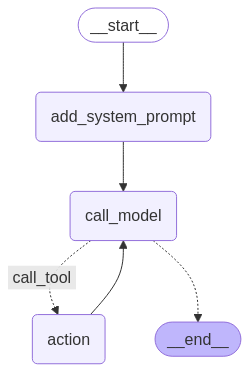

In [221]:
display(Image(app.get_graph().draw_mermaid_png()))

In [222]:
state = app.invoke(input={"question": ""})
print_state(state)

🔥🔥 Calling Model 🔥🔥 
🎯 Model Response:  
🎯 Model Tool Calls: [{'name': 'list_columns', 'args': {}, 'id': 'call_ezzn', 'type': 'tool_call'}] 
Checking Condition: Should Continue 🤔? 
Decision: Continue ✅(Call Tool) ---
🔥🔥 Calling Tool 🔥🔥
--- Executing Tool: list_columns ---
--- Tool Output: Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object') ---
🔥🔥 Calling Model 🔥🔥 
🎯 Model Response:  
🎯 Model Tool Calls: [{'name': 'list_columns', 'args': {}, 'id': 'call_4ny6', 'type': 'tool_call'}, {'name': 'column_dropper', 'args': {'null_threshold_percent': 0.5}, 'id': 'call_k2bh', 'type': 'tool_call'}] 
Checking Condition: Should Continue 🤔? 
Decision: Continue ✅(Call Tool) ---
🔥🔥 Calling Tool 🔥🔥
--- Executing Tool: list_columns ---
--- Tool Output: Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Resi

In [193]:
df_clean = pd.DataFrame.from_dict(toolkit.df_state)

In [194]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 519.0+ KB


### Testing

In [28]:
from langchain_core.utils.function_calling import convert_to_openai_function, convert_to_openai_tool

In [31]:
def foo(df: dict):
    return df


convert_to_openai_tool(foo)

{'type': 'function',
 'function': {'name': 'foo',
  'description': '',
  'parameters': {'properties': {'df': {'type': 'object'}},
   'required': ['df'],
   'type': 'object'}}}

In [73]:
convert_to_openai_tool(imputation_tools[0])

{'type': 'function',
 'function': {'name': 'simple_imputer',
  'description': "Imputes missing values (NaN) in a single column using a simple strategy: 'mean' (numeric only), 'median' (numeric only), or 'most_frequent' (mode, for any type). Returns a status message indicating success or failure.",
  'parameters': {'properties': {'column_name': {'description': 'The name of the column to impute.',
     'type': 'string'},
    'strategy': {'description': "The imputation strategy to use ('mean', 'median', or 'most_frequent'). 'mean'/'median' require numeric columns.",
     'enum': ['mean', 'median', 'most_frequent'],
     'type': 'string'}},
   'required': ['column_name', 'strategy'],
   'type': 'object'}}}